In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import SGD
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

## Read the dataset from the file

Read the dataset with semicolon seperated CSV file.

In [3]:
df_original = pd.read_csv('./bank-additional/bank.csv',sep=";")

Check if there are missing values (null) and confirm that there are no missing values present in any column.

In [4]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


## Identify the numerical columns and their distributions.

In [5]:
numerical_df = df_original.select_dtypes(include=np.number)
numerical_df.info()

numerical_df = numerical_df.drop(['duration'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       4521 non-null   int64
 1   balance   4521 non-null   int64
 2   day       4521 non-null   int64
 3   duration  4521 non-null   int64
 4   campaign  4521 non-null   int64
 5   pdays     4521 non-null   int64
 6   previous  4521 non-null   int64
dtypes: int64(7)
memory usage: 247.4 KB


In [6]:
numerical_df.describe()

,age,balance,day,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,50.000000,871.000000,25.000000


In [7]:
numerical_df.corr()

,age,balance,day,campaign,pdays,previous
age,1.000000,0.083820,-0.017853,-0.005148,-0.008894,-0.003511
balance,0.083820,1.000000,-0.008677,-0.009976,0.009437,0.026196
day,-0.017853,-0.008677,1.000000,0.160706,-0.094352,-0.059114
campaign,-0.005148,-0.009976,0.160706,1.000000,-0.093137,-0.067833
pdays,-0.008894,0.009437,-0.094352,-0.093137,1.000000,0.577562
previous,-0.003511,0.026196,-0.059114,-0.067833,0.577562,1.000000


### Drop pdays due to the collinearity 

In [8]:
numerical_df.drop(['day'], axis=1, inplace=True)

## Preprocess the numerical columns

draw boxplot, histogram and Q-Q plot to identify skewness and outlier if any.

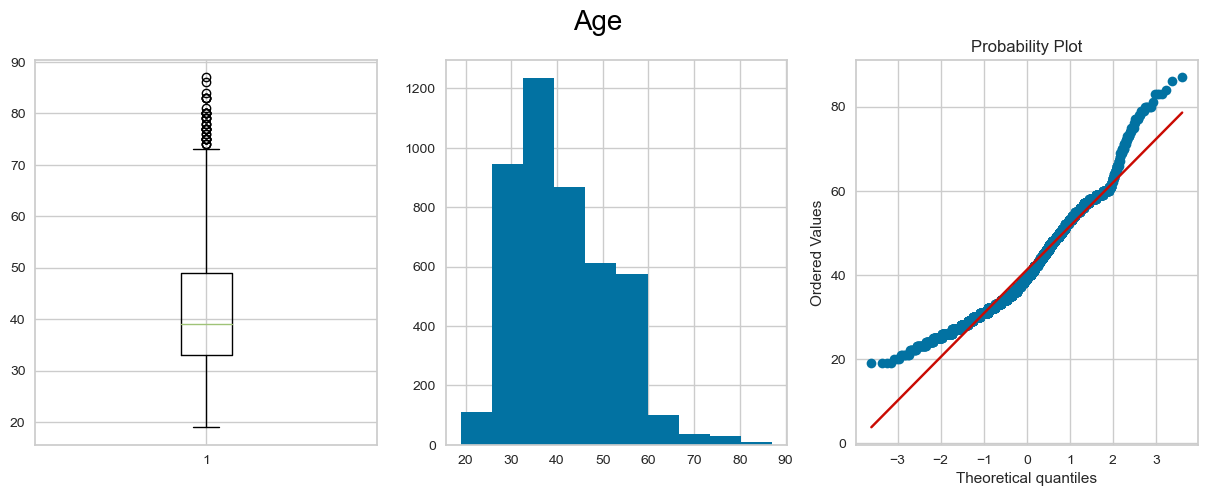

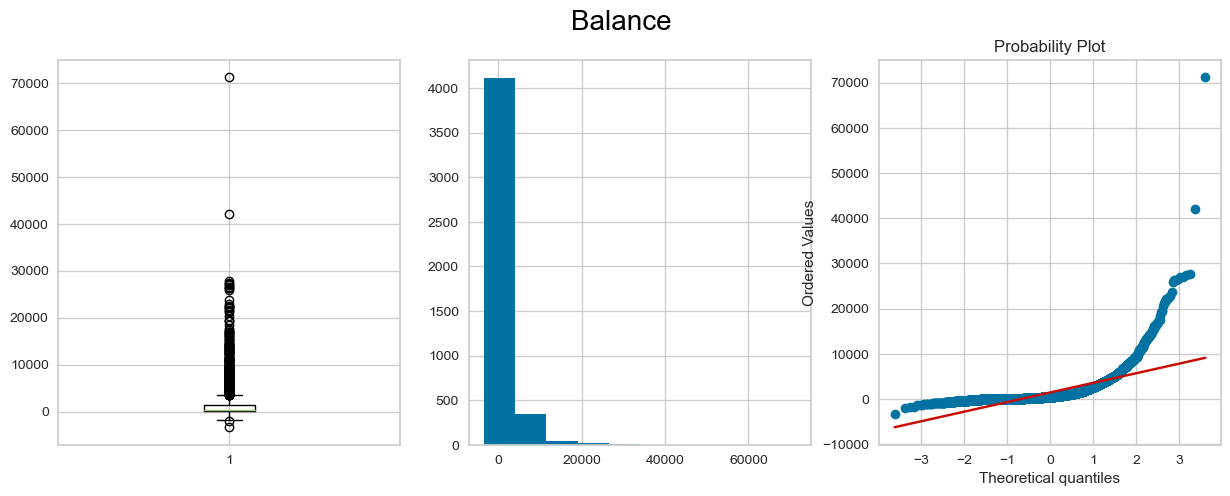

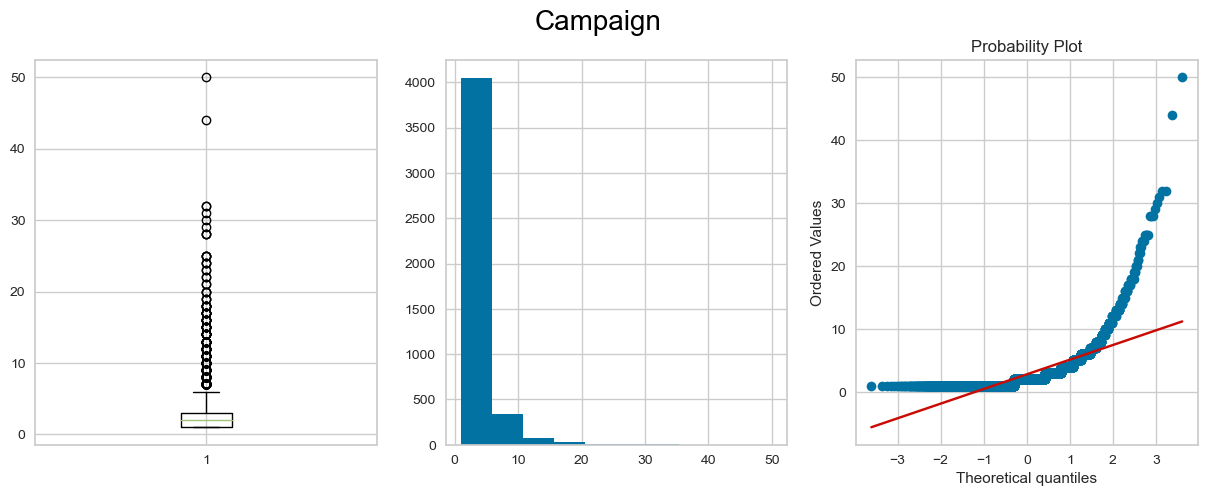

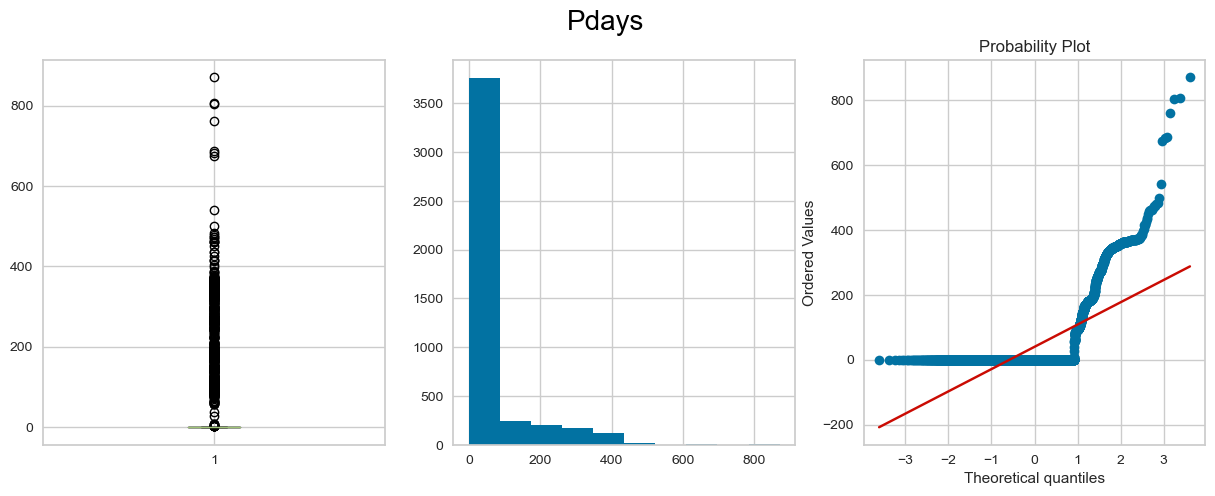

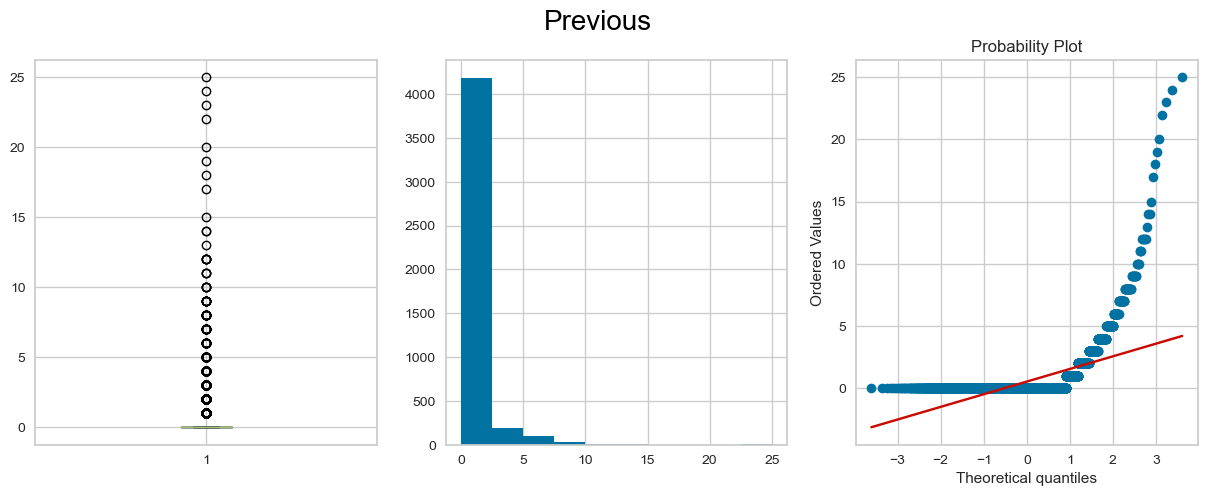

In [9]:
cols = numerical_df.columns

for col in cols:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    fig.suptitle(col.capitalize(), fontsize=20, color='Black')
    axes[0].boxplot(numerical_df[col])
    axes[1].hist(numerical_df[col])
    stats.probplot(numerical_df[col], dist="norm", plot=axes[2])
    plt.show()

We can see Age, Campaign, previous (min=0) are right skewed. We will use log transformation.

#### Right Skewed Data - Logarithmic Transformation

In [10]:
logarithmic_transformation = FunctionTransformer(np.log1p, validate=True)

log = ['age', 'campaign', 'previous','balance']
data_new = logarithmic_transformation.transform(numerical_df[log])
df_right_skewed = pd.DataFrame(data_new, columns=log)
#df_right_skewed = df_right_skewed.reset_index(drop=True) #turn the index back into a column
numerical_df['age'] = df_right_skewed["age"]
numerical_df["campaign"] = df_right_skewed["campaign"]
numerical_df["previous"] = df_right_skewed["previous"]
numerical_df['balance'] = df_right_skewed["balance"]


#### Left Skewed Data - Exponential Transformation (ignore)
Nr.employed is left skewed. We will use x^2 to do the transformation.

In [11]:
#squared_transformer = FunctionTransformer(lambda x: x**2, validate=True)

#to_squared = ['nr.employed']
#data_new = squared_transformer.transform(numerical_df[to_squared])
#df_left_skewed = pd.DataFrame(data_new, columns=to_squared)
#df_right_skewed = df_right_skewed.reset_index(drop=True) #turn the index back into a column
#numerical_df['nr.employed'] = df_left_skewed['nr.employed']


## Identify the categorical columns.

In [12]:
cat_df = df_original.select_dtypes(exclude=np.number)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job        4521 non-null   object
 1   marital    4521 non-null   object
 2   education  4521 non-null   object
 3   default    4521 non-null   object
 4   housing    4521 non-null   object
 5   loan       4521 non-null   object
 6   contact    4521 non-null   object
 7   month      4521 non-null   object
 8   poutcome   4521 non-null   object
 9   y          4521 non-null   object
dtypes: object(10)
memory usage: 353.3+ KB


## Preprocess categorical features

Code using one hot encoder

##### handle_unknown : {'error', 'ignore'}, default='error'
    Whether to raise an error or ignore if an unknown categorical feature
    is present during transform (default is to raise). When this parameter
    is set to 'ignore' and an unknown category is encountered during
    transform, the resulting one-hot encoded columns for this feature
    will be all zeros. In the inverse transform, an unknown category
    will be denoted as None.

In [13]:
cat_df["marital"].value_counts()

married     2797
single      1196
divorced     528
Name: marital, dtype: int64

In [14]:
cat_df["Relationship_status"] = cat_df["marital"].replace({"married":"partner", "single":"single", "divorced":"single", "unkown":"unknow",})

In [15]:
cat_df["education"].value_counts()

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

In [16]:
cat_df.drop(['marital'],axis=1,inplace=True)

In [17]:
#Get list of categorical variables
s = (cat_df.dtypes == 'object')
object_cols = list(s[s].index)
object_cols.remove('month')
print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['job', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y', 'Relationship_status']


In [18]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    cat_df[i]=cat_df[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [19]:
#cat_y_df = pd.concat([cat_df, df_original.y], axis='columns')

In [20]:
cat_df.drop(['month'], axis=1, inplace=True)

In [21]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   job                  4521 non-null   int32
 1   education            4521 non-null   int32
 2   default              4521 non-null   int32
 3   housing              4521 non-null   int32
 4   loan                 4521 non-null   int32
 5   contact              4521 non-null   int32
 6   poutcome             4521 non-null   int32
 7   y                    4521 non-null   int32
 8   Relationship_status  4521 non-null   int32
dtypes: int32(9)
memory usage: 159.1 KB


## Merge the two dfs

In [22]:
final_df = cat_df.join(numerical_df)  #need add y
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job                  4521 non-null   int32  
 1   education            4521 non-null   int32  
 2   default              4521 non-null   int32  
 3   housing              4521 non-null   int32  
 4   loan                 4521 non-null   int32  
 5   contact              4521 non-null   int32  
 6   poutcome             4521 non-null   int32  
 7   y                    4521 non-null   int32  
 8   Relationship_status  4521 non-null   int32  
 9   age                  4521 non-null   float64
 10  balance              4160 non-null   float64
 11  campaign             4521 non-null   float64
 12  pdays                4521 non-null   int64  
 13  previous             4521 non-null   float64
dtypes: float64(4), int32(9), int64(1)
memory usage: 335.7 KB


In [23]:
ds = final_df.copy()
ds =ds[~ds.isin([np.nan, np.inf, -np.inf]).any(1)] #ds contains y

ds_v2 = ds.copy()
#ds_v2.drop(['y'],axis=1,inplace=True)

In [24]:
scaler = StandardScaler()
scaler.fit(ds_v2)
ds_scaled = scaler.transform(ds_v2)
scaled_df = pd.DataFrame(ds_scaled,columns= ds_v2.columns)

### k-Means

#### Determine the optimal k clusters by using something called the elbow method

One thing to note, since k-Means typically uses Euclidean distance to calculate the distances it does not work well with high dimensional data sets due to the curse of dimensionality. This curse, in part, states that Euclidean distances at high dimensionality have very little meaning since they are often very close together.

Text(0.5, 1.0, 'Inertia of Cosine k-Means versus number of clusters')

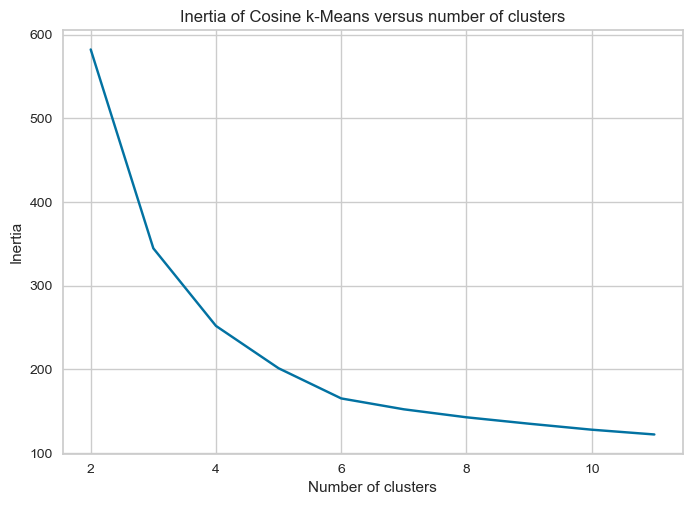

In [54]:
from sklearn import preprocessing
normalized_vectors = preprocessing.normalize(ds_v2)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_ for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")

In [55]:
normalized_kmeans = KMeans(n_clusters=3)
normalized_kmeans.fit(normalized_vectors)

KMeans(n_clusters=3)

### DBSCAN

In [56]:
from sklearn.cluster import KMeans, DBSCAN
min_samples = ds_v2.shape[1]+1 #  Rule of thumb; number of dimensions D in the data set, as minPts ≥ D + 1
dbscan = DBSCAN(eps=3.5, min_samples=min_samples).fit(ds_v2)

## Visualization

## Do the PCA to feature reduction

<AxesSubplot:xlabel='x', ylabel='y'>

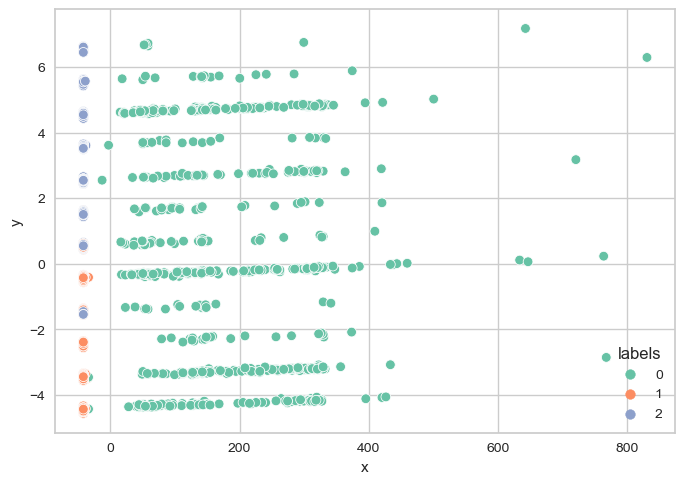

In [57]:
def prepare_pca(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

pca_df = prepare_pca(3, ds_v2, normalized_kmeans.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, palette="Set2")

In [58]:
import plotly.express as px
def plot_3d(df, name='labels'):
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                  color=name, opacity=0.5)
    

    fig.update_traces(marker=dict(size=3))
    fig.show()
pca_df = prepare_pca(3, ds_v2, normalized_kmeans.labels_)
plot_3d(pca_df)

##  Evaluating Clusters

In [59]:
kmeans = KMeans(n_clusters=3).fit(ds_v2)

normalized_vectors = preprocessing.normalize(ds_v2)
normalized_kmeans = KMeans(n_clusters=3).fit(normalized_vectors)

min_samples = ds_v2.shape[1]+1 #  Rule of thumb; number of dimensions D in the data set, as minPts ≥ D + 1
dbscan = DBSCAN(eps=3.5, min_samples=min_samples).fit(ds_v2)

In [60]:
from sklearn.metrics import silhouette_score
print('kmeans: {}'.format(silhouette_score(ds_v2, kmeans.labels_, metric='euclidean')))
print('Cosine kmeans: {}'.format(silhouette_score(normalized_vectors, normalized_kmeans.labels_, metric='cosine')))
print('DBSCAN: {}'.format(silhouette_score(ds_v2, dbscan.labels_, metric='cosine')))

kmeans: 0.8924458530910204
Cosine kmeans: 0.6267633671191284
DBSCAN: 0.5533148778264804


The closer the value of the silhouette score to 1 the better-separated the clusters.

## What makes a cluster unique

In [61]:
from sklearn.preprocessing import MinMaxScaler

# Setting all variables between 0 and 1 in order to better visualize the results
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(ds_v2))
df_scaled.columns = ds_v2.columns
df_scaled['kmeans'] = kmeans.labels_

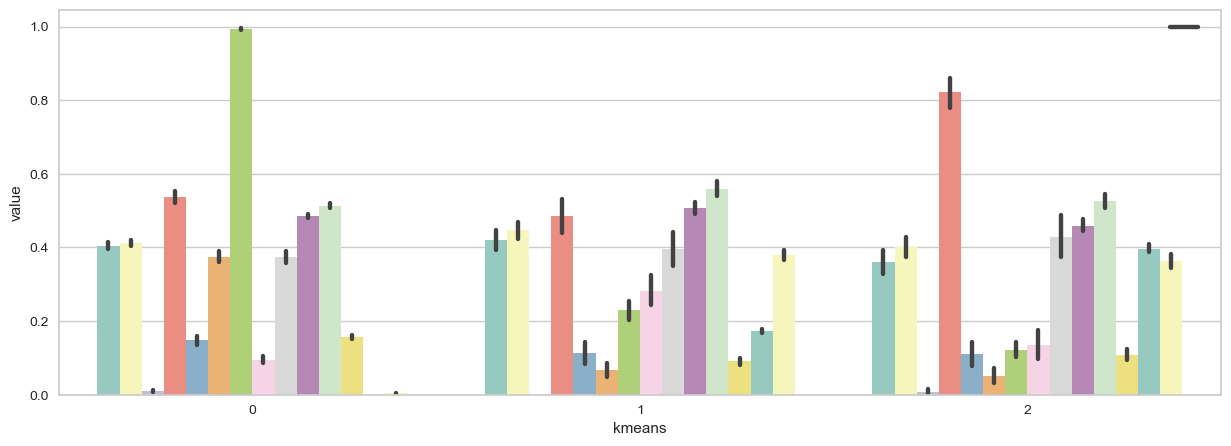

In [62]:
# df = load_preprocess_data()
ds_v2['kmeans'] = kmeans.labels_
tidy = df_scaled.melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend([''])
# plt.savefig("mess.jpg", dpi=300)
plt.savefig("kmeans_mess.jpg", dpi=300)

The problem with this approach is that we simply have too many variables. Not all of them are likely to be important when creating the clusters. Instead, I will select the most important columns based on the following approach:

## Variance

What I essentially do is group datapoints by cluster and take the average. Then, I calculate the standard deviation between those values for each variable. Variables with a high standard deviation indicate that there are large differences between clusters and that the variable might be important.

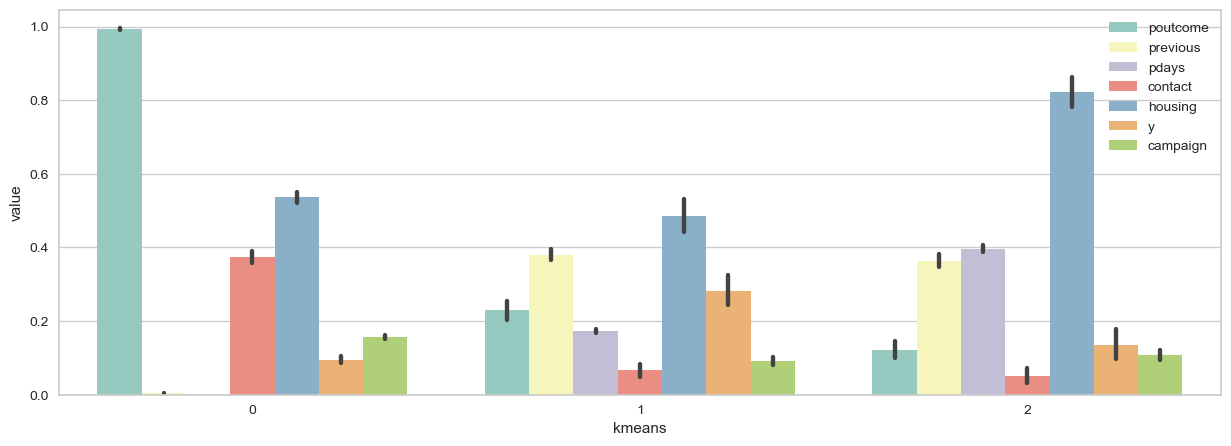

In [63]:
df_mean = df_scaled.loc[df_scaled.kmeans!=-1, :].groupby('kmeans').mean().reset_index()
results = pd.DataFrame(columns=['Variable', 'Std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('Std', ascending=False).head(7).Variable.values) + ['kmeans']

# Plot data
tidy = df_scaled[selected_columns].melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper right')
plt.savefig("kmeans_results.jpg", dpi=300)

In [64]:
selected_columns

['poutcome',
 'previous',
 'pdays',
 'contact',
 'housing',
 'y',
 'campaign',
 'kmeans']

## Feature Importance

In [65]:
from sklearn.ensemble import RandomForestClassifier
y = ds_v2.iloc[:,-1]
X = ds_v2.iloc[:,:-1]
clf = RandomForestClassifier(n_estimators=100).fit(X, y)
selected_columns = list(pd.DataFrame(np.array([clf.feature_importances_, X.columns]).T, columns=['Importance', 'Feature'])
           .sort_values("Importance", ascending=False)
           .head(7)
           .Feature
           .values)

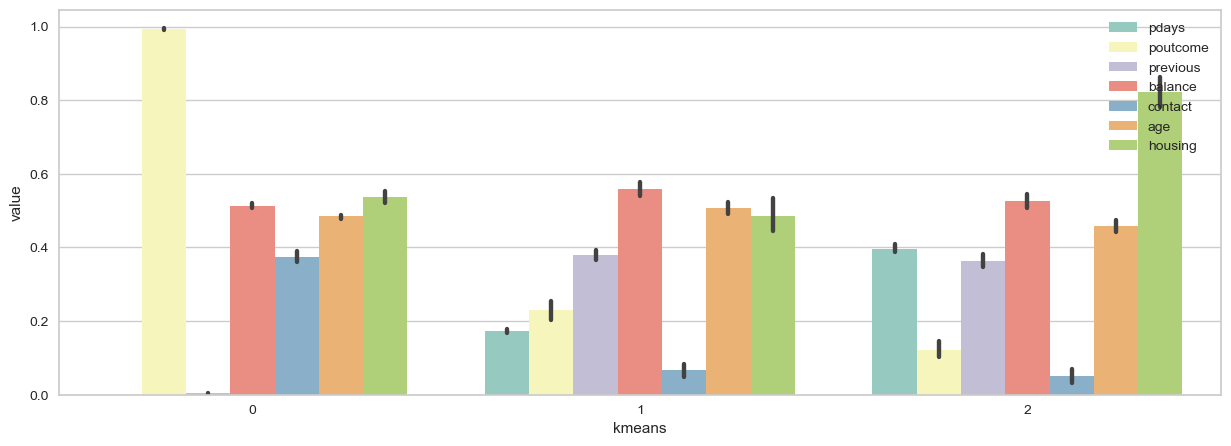

In [66]:

# Plot data
tidy = df_scaled[selected_columns+['kmeans']].melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper right')
plt.savefig('randomforest.jpg', dpi=300)

We can see that similar features are selected when comparing to the variance analysis that we did before. Since this method requires a bit more work in the form of validation I would suggest using the variance method described before.

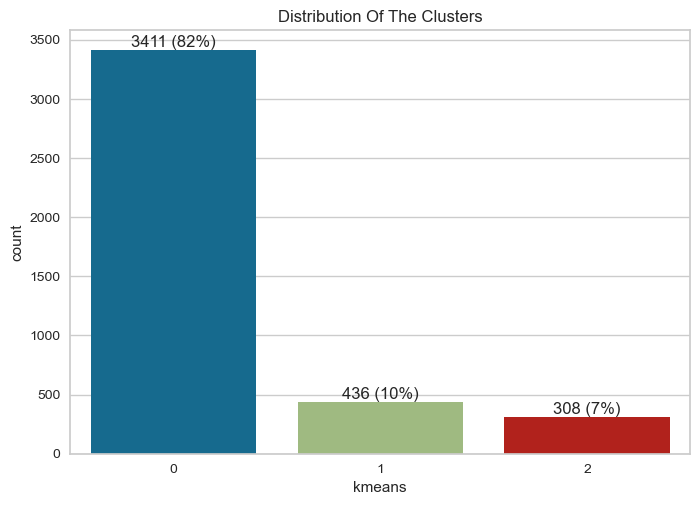

In [67]:
#Plotting countplot of clusters
ax = sns.countplot(x=df_scaled["kmeans"])
abs_values = df_scaled["kmeans"].value_counts(ascending=False)
rel_values = df_scaled["kmeans"].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)
ax.set_title("Distribution Of The Clusters")
plt.show()

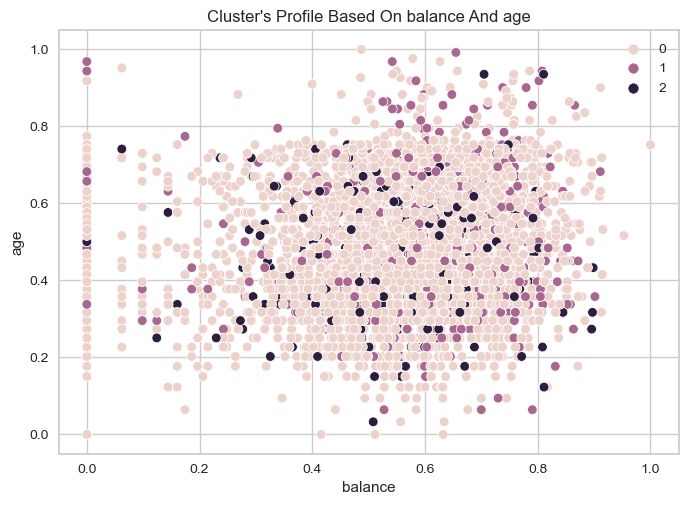

In [68]:
pl = sns.scatterplot(data = df_scaled,x=df_scaled["balance"], y=df_scaled["age"],hue=df_scaled["kmeans"])
pl.set_title("Cluster's Profile Based On balance And age")
plt.legend()
plt.show()

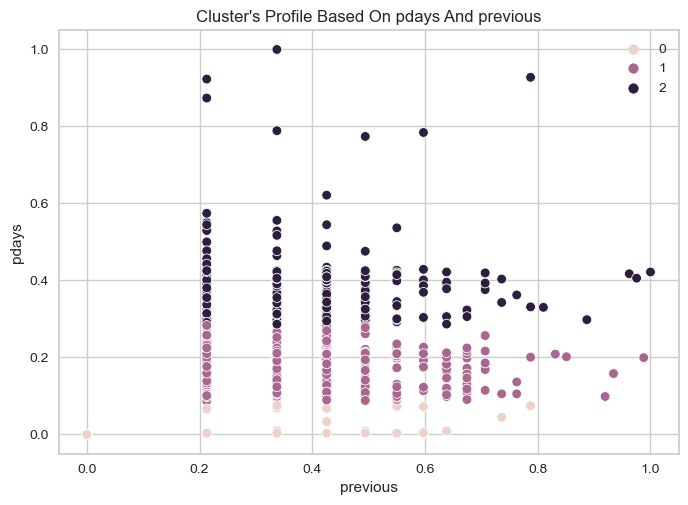

In [69]:
pl = sns.scatterplot(data = ds,x=df_scaled["previous"], y=df_scaled["pdays"],hue=df_scaled["kmeans"])
pl.set_title("Cluster's Profile Based On pdays And previous")
plt.legend()
plt.show()

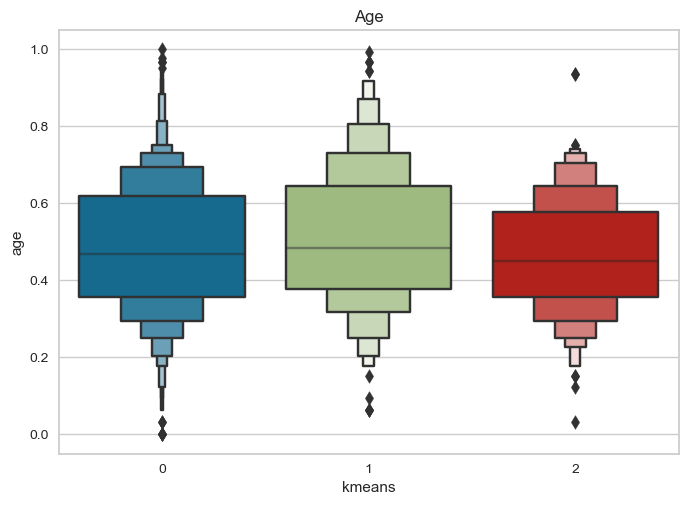

In [70]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df_scaled["age"],x=df_scaled["kmeans"])
pl.set_title("Age")
plt.show()

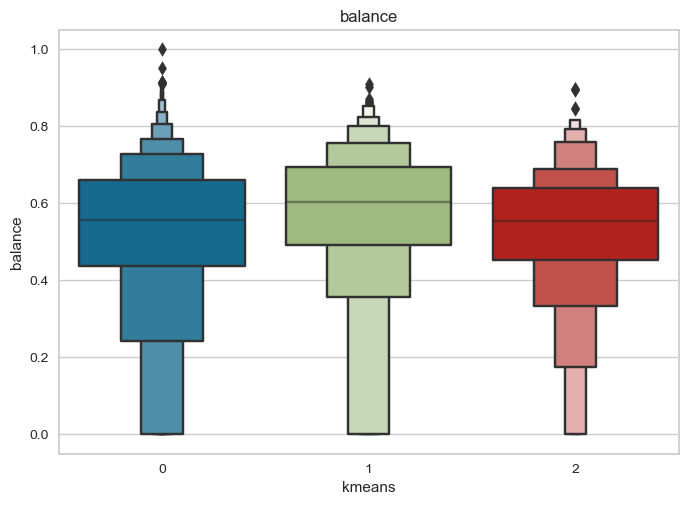

In [71]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df_scaled["balance"],x=df_scaled["kmeans"])
pl.set_title("balance")
plt.show()

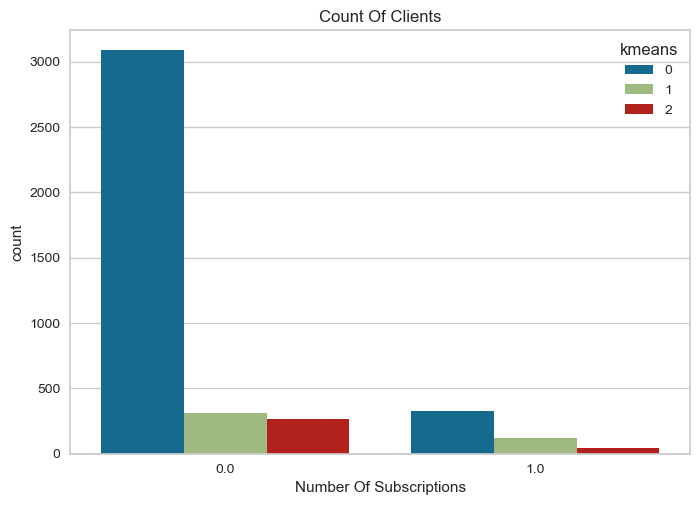

In [73]:
plt.figure()
pl = sns.countplot(x=df_scaled["y"],hue=df_scaled["kmeans"])
pl.set_title("Count Of Clients")
pl.set_xlabel("Number Of Subscriptions")
plt.show()

<AxesSubplot:title={'center':'Subscription% vs Cluster'}, ylabel='No_Subscription%'>

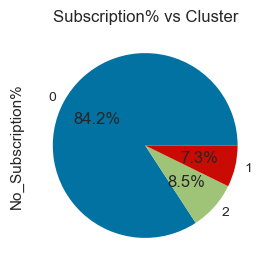

In [45]:
filter0=(df_scaled['y']==0)
age0=df_scaled.loc[filter0, ['kmeans','y']].kmeans.value_counts()

filter1=(df_scaled['y']==1)
age1=df_scaled.loc[filter1, ['kmeans','y']].kmeans.value_counts()


no_perc=age0/(age0.sum())
no_perc.plot(kind='pie', xlabel='Cluster', ylabel='No_Subscription%', title='Subscription% vs Cluster',figsize=(12,3), autopct='%.1f%%')

<AxesSubplot:title={'center':'Subscription% vs Cluster'}, ylabel='Yes_Subscription%'>

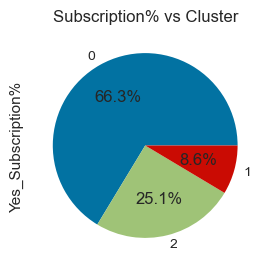

In [46]:

yes_perc=age1/(age1.sum())
yes_perc.plot(kind='pie', xlabel='Cluster', ylabel='Yes_Subscription%', title='Subscription% vs Cluster',figsize=(12,3), autopct='%.1f%%')

<AxesSubplot:title={'center':'Subscription% vs Cluster0'}, ylabel='y'>

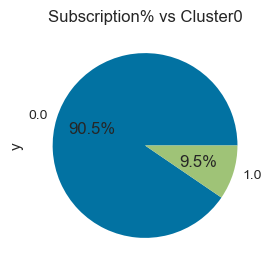

In [47]:
filter0=(df_scaled['kmeans']==0)
age0=df_scaled.loc[filter0, ['kmeans','y']].y.value_counts()

no_perc=age0/(age0.sum())
no_perc.plot(kind='pie', xlabel='Cluster', title='Subscription% vs Cluster0',figsize=(12,3),autopct='%.1f%%')

<AxesSubplot:title={'center':'Subscription% vs Cluster1'}, ylabel='y'>

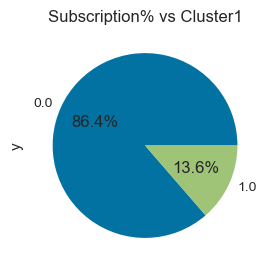

In [48]:
filter0=(df_scaled['kmeans']==1)
age0=df_scaled.loc[filter0, ['kmeans','y']].y.value_counts()

no_perc=age0/(age0.sum())
no_perc.plot(kind='pie', xlabel='Cluster', title='Subscription% vs Cluster1',figsize=(12,3),autopct='%.1f%%')

<AxesSubplot:title={'center':'Subscription% vs Cluster2'}, ylabel='y'>

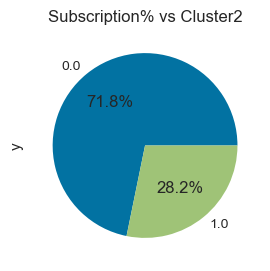

In [49]:
filter0=(df_scaled['kmeans']==2)
age0=df_scaled.loc[filter0, ['kmeans','y']].y.value_counts()

no_perc=age0/(age0.sum())
no_perc.plot(kind='pie', xlabel='Cluster', title='Subscription% vs Cluster2',figsize=(12,3), autopct='%.1f%%')

In [50]:
len(df_scaled[df_scaled['y']==1])/len(df_scaled)

0.11793020457280386

## Narrow down the population of the client to 7% (cluster2), the subscription rate increases from 11.8% to 28.2%.